**This notebook explores data from user sessions from a travel start-up TravelTide.**  
The purpose is to develope user segments for a marketing rewarding program

In [ ]:
import os
from dotenv import load_dotenv
import importlib

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 

from customer_segmentation.utils import functions
importlib.reload(functions)
from customer_segmentation.utils import queries
importlib.reload(queries)

# Set pandas to display all columns
pd.set_option('display.max_columns', None)

load_dotenv(override=True, verbose=False)

True

**Query data & data type transformations**

In [11]:
cohort = functions.read_from_db(queries.query_user)

display(cohort.shape)
display(pd.DataFrame({"dtypes": cohort.dtypes}).T)
cohort.head(3)

(84579, 25)

,user_id,age,is_female,is_married,has_children,cnt_trips,cnt_sessions,page_clicks,cnt_cancellations,cnt_booked_flights,cnt_booked_hotels,cnt_flight_discount,cnt_hotel_discount,min_user_date,max_user_date,days_active_age,last_trip_date,avg_diff_trip_days,last_trip_age,cnt_checked_bags,sum_seats,sum_travel_days,sum_base_fare_usd,sum_nights,sum_hotel_usd
dtypes,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,object,object,int64,object,float64,int64,int64,float64,float64,float64,float64,float64


,user_id,age,is_female,is_married,has_children,cnt_trips,cnt_sessions,page_clicks,cnt_cancellations,cnt_booked_flights,cnt_booked_hotels,cnt_flight_discount,cnt_hotel_discount,min_user_date,max_user_date,days_active_age,last_trip_date,avg_diff_trip_days,last_trip_age,cnt_checked_bags,sum_seats,sum_travel_days,sum_base_fare_usd,sum_nights,sum_hotel_usd
0,264579,26,1,0,0,2,8,140,0,2,2,1,2,2022-07-28,2023-04-27,273,2022-08-23,26.0,247,2,2.0,7.0,306.0,5.0,3180.0
1,264581,21,0,0,1,1,7,59,0,0,1,3,3,2022-07-28,2023-07-10,347,2022-08-09,0.0,335,0,0.0,0.0,0.0,8.0,1320.0
2,264584,46,0,1,0,4,8,160,0,4,4,2,0,2022-07-28,2023-03-08,223,2023-01-07,163.0,60,4,4.0,18.0,2375.0,15.0,3218.0


In [5]:
# convert data types
cohort['user_id'] = cohort['user_id'].astype(str)
cohort['max_user_date'] = pd.to_datetime(cohort['max_user_date'])
cohort['min_user_date'] = pd.to_datetime(cohort['min_user_date'])
cohort['last_trip_date'] = pd.to_datetime(cohort['last_trip_date'])

**create meaningful KPIs**

In [ ]:
# activity & engagement
cohort['month_active'] = cohort['days_active_age'] / 30
cohort['page_click_per_session'] = cohort['page_clicks'] / cohort['cnt_sessions']
cohort['trips_per_active_month'] = cohort['cnt_trips'] / cohort['month_active']

# bookings, discount & cancellations
cohort['cnt_bookings'] = cohort['cnt_booked_flights'] + cohort['cnt_booked_hotels']
cohort['total_booking_value'] = cohort['sum_hotel_usd'] + cohort['sum_base_fare_usd']
cohort['avg_booking_value'] = cohort['total_booking_value'] / cohort['cnt_bookings']

cohort['has_cancelled'] = (cohort['cnt_cancellations'] > 0).astype(int)
cohort['is_flight_discount'] = (cohort['cnt_flight_discount'] > 0).astype(int)
cohort['is_hotel_discount'] = (cohort['cnt_hotel_discount'] > 0).astype(int)
cohort['has_booked_flight'] = (cohort['cnt_booked_flights'] > 0).astype(int)
cohort['has_booked_hotel'] = (cohort['cnt_booked_hotels'] > 0).astype(int)
cohort['has_baggage'] = (cohort['cnt_checked_bags'] > 0).astype(int)

'''
TODO:
avg travel duration for flight -> sum travel days / cnt flight bookings
avg seats -> sum seats / cnt flight bookings
avg bags -> sum bags / cnt flight bookings

avg value per user -> sum cost / (cnt flight bookings + cnt flight bookings)
avg value per user -> avg cost / (cnt flight bookings + cnt flight bookings)

avg days between bookings
'''


In [147]:
# remove columns not necessary for further analysis
columns_to_drop = ['cnt_flight_discount', 'cnt_hotel_discount', 'cnt_cancellations', 'cnt_sessions', 
                   'cnt_booked_hotels', 'cnt_booked_flights', 'cnt_checked_bags', 'days_active_age', 
                   'sum_base_fare_usd', 'sum_hotel_usd', 'total_booking_value', 'max_user_date', 
                   'last_trip_date']
cohort = cohort.drop(columns=columns_to_drop)

In [148]:
# list all metrics
binary_cols = functions.get_binary_columns(cohort)
numeric_cols = cohort.select_dtypes(include=[np.number]).columns.drop(binary_cols)
sorted(numeric_cols.to_list())

['age',
 'avg_booking_value',
 'avg_nights',
 'cnt_bookings',
 'cnt_trips',
 'last_trip_age',
 'month_active',
 'page_click_per_session',
 'page_clicks',
 'trips_per_active_month']

In [149]:
# list binaries
sorted(binary_cols)

['has_baggage',
 'has_booked_flight',
 'has_booked_hotel',
 'has_cancelled',
 'has_children',
 'is_female',
 'is_flight_discount',
 'is_hotel_discount',
 'is_married']

In [150]:
cohort[numeric_cols].describe()

,age,cnt_trips,page_clicks,last_trip_age,avg_nights,month_active,page_click_per_session,trips_per_active_month,cnt_bookings,avg_booking_value
count,84579.000000,84579.000000,84579.000000,84579.000000,84579.000000,84579.000000,84579.000000,84579.000000,84579.000000,70211.000000
mean,40.631918,1.584412,89.122288,91.409440,3.955178,5.493675,15.611463,0.357126,2.658059,981.894226
std,14.601953,1.131874,44.797650,79.049023,4.163409,2.366778,8.624751,0.350225,2.077724,1165.778440
min,18.000000,0.000000,10.000000,0.000000,0.000000,1.000000,2.400000,0.000000,0.000000,0.000000
25%,29.000000,1.000000,60.000000,0.000000,0.000000,3.700000,11.000000,0.142857,1.000000,379.375000
50%,38.000000,1.000000,81.000000,86.000000,3.000000,5.400000,14.142857,0.272727,2.000000,601.000000
75%,50.000000,2.000000,108.000000,157.000000,6.000000,7.100000,18.000000,0.476190,4.000000,1102.600000
max,90.000000,7.000000,708.000000,354.000000,30.000000,11.900000,156.000000,3.870968,14.000000,32760.000000


In [151]:
share_user_not_booked = cohort[cohort['cnt_trips'] == 0]['user_id'].nunique() / cohort['user_id'].nunique()
print(f"Percent share of users without bookings: {share_user_not_booked * 100:.1f}%")

high_booking_values = cohort[(cohort['avg_booking_value'] >= 5000) & (cohort['cnt_trips'] > 0)]['user_id'].nunique() / cohort['user_id'].nunique()
print(f"Percent share of users with high booking values: {high_booking_values * 100:.1f}%") # users with outlier values have booked (keep them)

Percent share of users without bookings: 17.0%
Percent share of users with high booking values: 1.3%


Distribution of all numeric features, filtered values (0 values excluded which indicate no bookings)

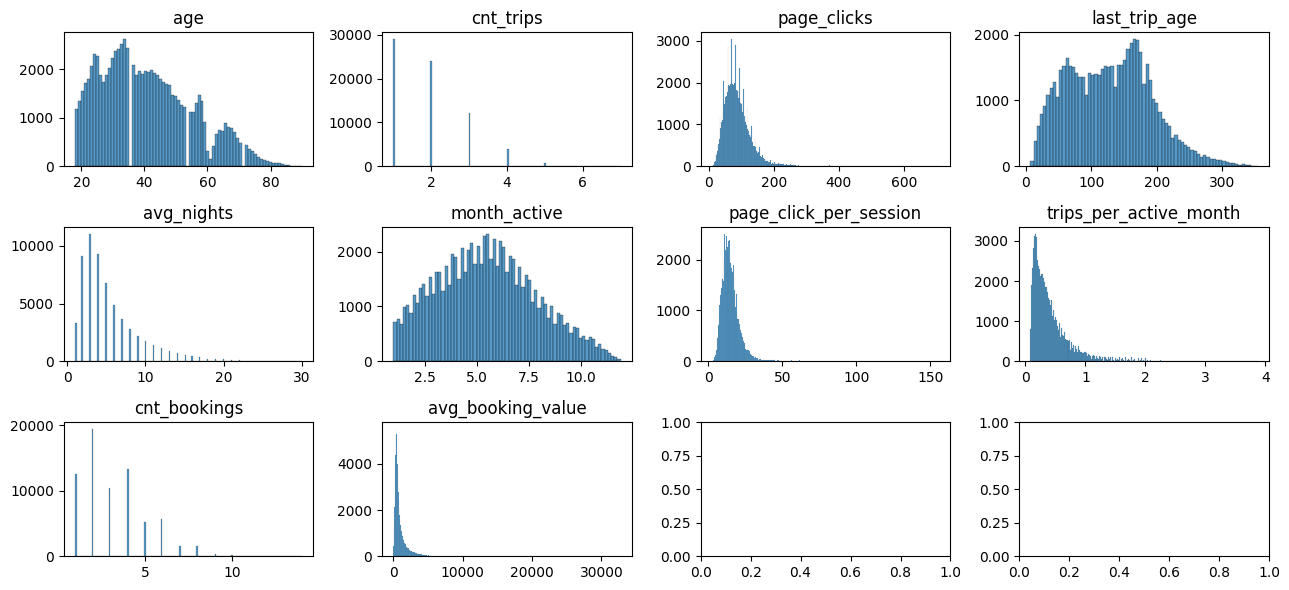

In [152]:
functions.plot_univariate_series(df=cohort, metrics=numeric_cols.to_list(), n_cols=4, plot_type=sns.histplot)

**Aggregated values per first session per user**

In [153]:
# aggregate by min session date
user_grouped_per_min_date = cohort.groupby(['min_user_date']).agg(
    cnt_user = ('user_id', 'nunique'),
    page_clicks = ('page_clicks', 'sum'),
    cnt_trips = ('cnt_trips', 'sum'),
    last_trip_user_age = ('last_trip_age', 'mean'),
    days_active_age = ('month_active', 'mean'),
    avg_booking_value = ('avg_booking_value', 'mean'),
    last_trip_age = ('last_trip_age', 'sum'),
    trips_per_active_month = ('trips_per_active_month', 'sum'),
).reset_index()

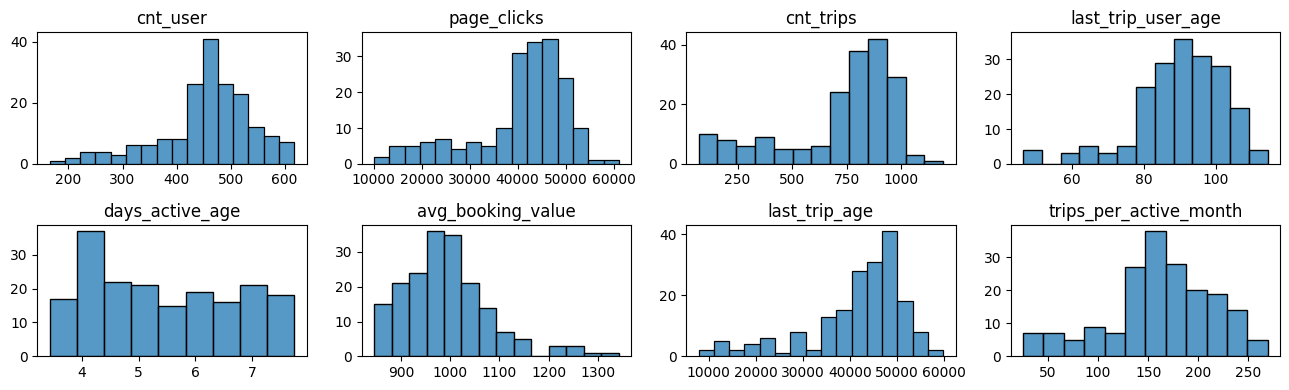

In [154]:
metrics = user_grouped_per_min_date.select_dtypes(include = [np.number]).columns.to_list()

functions.plot_univariate_series(df=user_grouped_per_min_date, metrics=metrics, n_cols=4, plot_type=sns.histplot)

**discover user pattern over time**  
 
- activity decreases overall over time  
- average duration between last booking and last session is stable

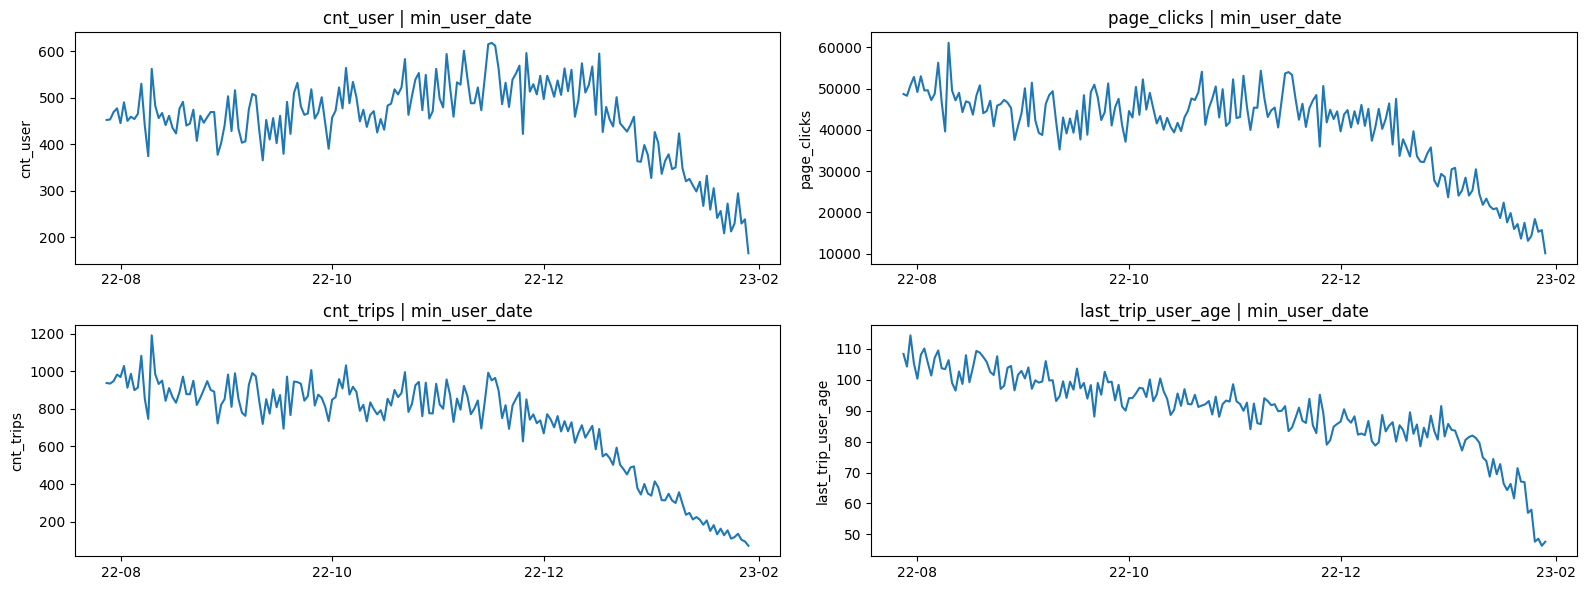

In [155]:
functions.plot_time_series(df=user_grouped_per_min_date, x=user_grouped_per_min_date.columns.values[0], y=list(user_grouped_per_min_date.columns.values[1:]))

**get an overall view of user pattern aggregated per month and year**  

- average activity decreases while bookings and clicks increases over time (last month drop can be due to seasonality)

In [ ]:
user_month = functions.read_from_db(queries.query_monthly_user)
user_month['yearmonth'] = pd.to_datetime(user_month['yearmonth'])

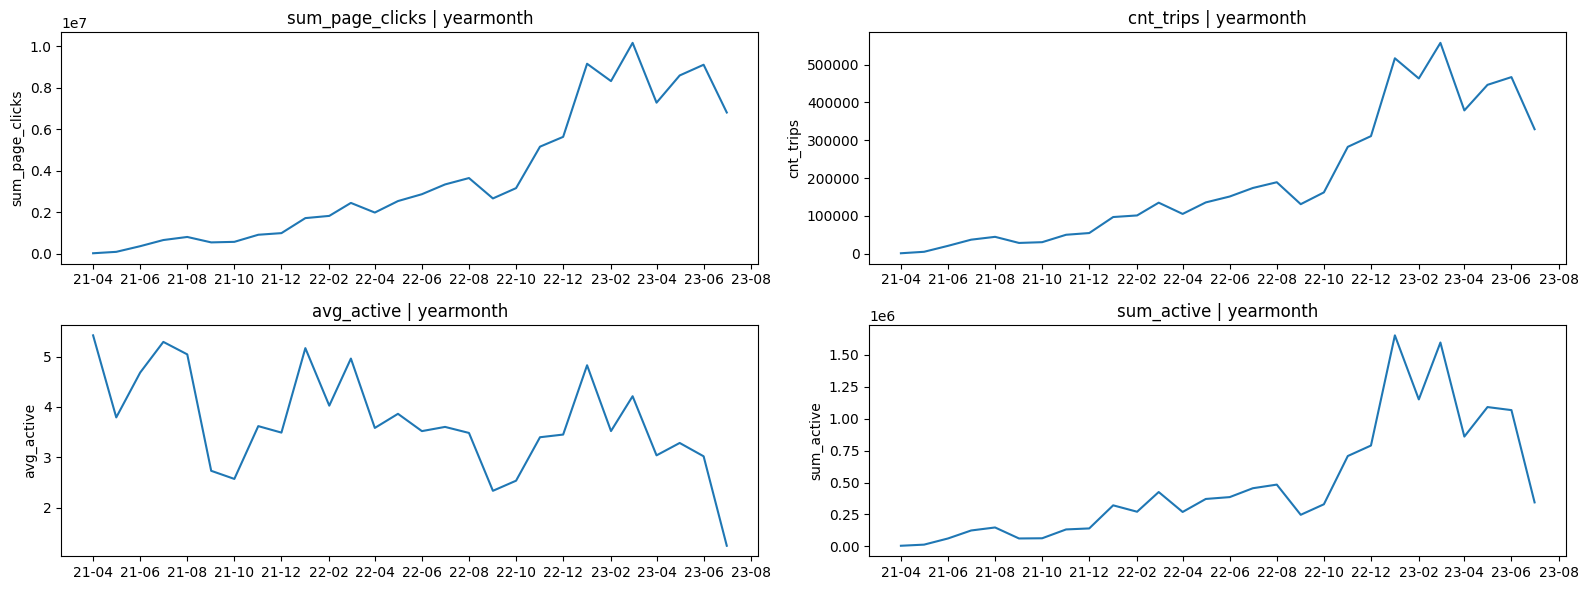

In [20]:
metrics = user_month.select_dtypes(include=[np.number]).columns.to_list()
functions.plot_time_series(df=user_month, x='yearmonth', y=metrics)

In [158]:
# export data to csv file

current_dir = os.getcwd()
data_dir = os.path.join(current_dir, os.path.pardir, "data")
data_path = os.path.join(data_dir, "cohort_data.csv")
cohort.to_csv(data_path, index=False)